<a href="https://colab.research.google.com/github/atul-lanka/asl_recognition/blob/main/ASL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#American Sign Language - Model Training

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet

from keras.layers import Flatten, Dense, Input, Dropout
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam

import numpy as np
import argparse
import os

##Dataset

In [ ]:
!unzip asl_alphabet.zip

In [ ]:
training_data = '/content/asl_alphabet_train'

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True, 
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2], rescale=1./255,
    rotation_range=15.0,
    width_shift_range=0.15,
    height_shift_range=0.15,
    validation_split = 0.2
)

train_generator = data_generator.flow_from_directory(training_data, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(training_data, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 71612 images belonging to 39 classes.
Found 17903 images belonging to 39 classes.


## Inception V3 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3


In [ ]:
inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in inception_v3_model.layers[:249]:
    layer.trainable = False
for layer in inception_v3_model.layers[249:]:
    layer.trainable = True

In [ ]:
inception_output = inception_v3_model.output

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
x = layers.Dense(39, activation='softmax')(x)           

model = Model(inception_v3_model.input, x) 

model.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback]
)

Epoch 1/50
100/100 [==============================] - 105s 1s/step - loss: 3.0618 - acc: 0.2502 - val_loss: 2.8253 - val_acc: 0.2375
Epoch 2/50
100/100 [==============================] - 103s 1s/step - loss: 1.8713 - acc: 0.5953 - val_loss: 2.0813 - val_acc: 0.4419
Epoch 3/50
100/100 [==============================] - 103s 1s/step - loss: 1.1364 - acc: 0.7353 - val_loss: 1.5731 - val_acc: 0.5794
Epoch 4/50
100/100 [==============================] - 102s 1s/step - loss: 0.7812 - acc: 0.8167 - val_loss: 1.2267 - val_acc: 0.6625
Epoch 5/50
100/100 [==============================] - 102s 1s/step - loss: 0.5903 - acc: 0.8548 - val_loss: 1.0976 - val_acc: 0.6819
Epoch 6/50
100/100 [==============================] - 103s 1s/step - loss: 0.4887 - acc: 0.8791 - val_loss: 0.9866 - val_acc: 0.7122
Epoch 7/50
100/100 [==============================] - 103s 1s/step - loss: 0.3965 - acc: 0.8955 - val_loss: 0.9351 - val_acc: 0.7203
Epoch 8/50
100/100 [==============================] - 103s 1s/step - 

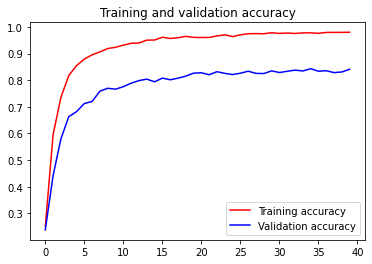

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

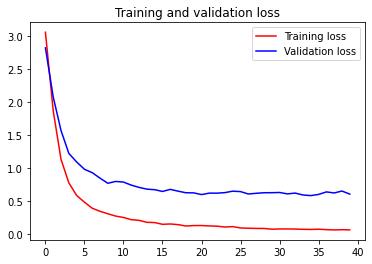

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
MODEL_NAME = '/content/asl_{}.h5'.format("inceptionv3")
model.save(MODEL_NAME)

## VGG16

In [ ]:
vgg16_model = VGG16(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in vgg16_model.layers[:15]:
    layer.trainable = False
for layer in vgg16_model.layers[15:]:
    layer.trainable = True

In [ ]:
vgg_output = vgg16_model.output

In [ ]:
x1 = layers.GlobalAveragePooling2D()(vgg_output)
x1 = layers.Dense(1024, activation='relu')(x1)
x1 = layers.Dropout(0.2)(x1)                  
x1 = layers.Dense(39, activation='softmax')(x1)           

model1 = Model(vgg16_model.input, x1) 

model1.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

history = model1.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback])

Epoch 1/50
100/100 [==============================] - 110s 1s/step - loss: 3.3827 - acc: 0.0856 - val_loss: 3.0503 - val_acc: 0.1816
Epoch 2/50
100/100 [==============================] - 109s 1s/step - loss: 2.1828 - acc: 0.4155 - val_loss: 1.3571 - val_acc: 0.6781
Epoch 3/50
100/100 [==============================] - 109s 1s/step - loss: 0.9060 - acc: 0.7447 - val_loss: 0.7418 - val_acc: 0.7834
Epoch 4/50
100/100 [==============================] - 110s 1s/step - loss: 0.5130 - acc: 0.8622 - val_loss: 0.4799 - val_acc: 0.8700
Epoch 5/50
100/100 [==============================] - 109s 1s/step - loss: 0.3374 - acc: 0.9106 - val_loss: 0.4112 - val_acc: 0.8850
Epoch 6/50
100/100 [==============================] - 109s 1s/step - loss: 0.2704 - acc: 0.9253 - val_loss: 0.3588 - val_acc: 0.8859
Epoch 7/50
100/100 [==============================] - 109s 1s/step - loss: 0.2310 - acc: 0.9336 - val_loss: 0.2966 - val_acc: 0.9050
Epoch 8/50
100/100 [==============================] - 109s 1s/step - 

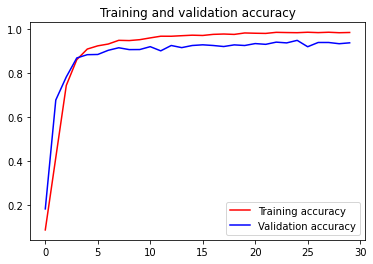

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

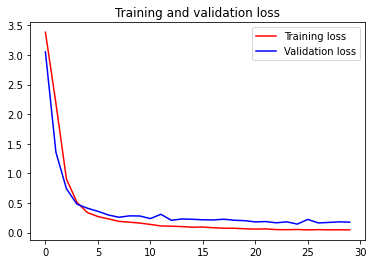

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
MODEL_NAME = '/content/asl_{}.h5'.format("vgg16")
model1.save(MODEL_NAME)

## ResNet50

In [ ]:
resnet50_model = ResNet50(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
    include_top = False, 
    weights = 'imagenet'
)

for layer in resnet50_model.layers[:-32]:
    layer.trainable = False
for layer in resnet50_model.layers[-32:]:
    layer.trainable = True

In [ ]:
resnet50_output = resnet50_model.output

In [ ]:
x2 = layers.GlobalAveragePooling2D()(resnet50_output)
x2 = layers.Dense(1024, activation='relu')(x2)
x2 = layers.Dropout(0.2)(x2)                  
x2 = layers.Dense(39, activation='softmax')(x2)           

model2 = Model(resnet50_model.input, x2) 

model2.compile(
    optimizer=SGD(lr=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 5)

history = model2.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch = 100,
    validation_steps=50,
    epochs=50, verbose =1,
    callbacks=[callback])

Epoch 1/50
100/100 [==============================] - 111s 1s/step - loss: 3.1196 - acc: 0.1730 - val_loss: 3.1028 - val_acc: 0.1637
Epoch 2/50
100/100 [==============================] - 110s 1s/step - loss: 2.0473 - acc: 0.4320 - val_loss: 2.3908 - val_acc: 0.3063
Epoch 3/50
100/100 [==============================] - 110s 1s/step - loss: 1.4637 - acc: 0.5828 - val_loss: 2.0236 - val_acc: 0.3894
Epoch 4/50
100/100 [==============================] - 110s 1s/step - loss: 1.1338 - acc: 0.6655 - val_loss: 1.8139 - val_acc: 0.4541
Epoch 5/50
100/100 [==============================] - 110s 1s/step - loss: 0.9547 - acc: 0.7153 - val_loss: 1.6345 - val_acc: 0.5016
Epoch 6/50
100/100 [==============================] - 110s 1s/step - loss: 0.7808 - acc: 0.7583 - val_loss: 1.5239 - val_acc: 0.5384
Epoch 7/50
100/100 [==============================] - 110s 1s/step - loss: 0.6890 - acc: 0.7903 - val_loss: 1.4721 - val_acc: 0.5541
Epoch 8/50
100/100 [==============================] - 110s 1s/step - 

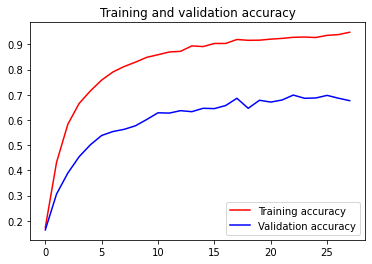

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

<Figure size 432x288 with 0 Axes>

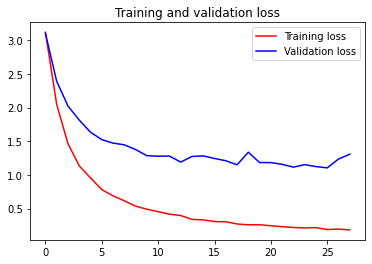

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

In [ ]:
MODEL_NAME = '/content/asl_{}.h5'.format("resnet50")
model2.save(MODEL_NAME)